## Введение

Гуляя по парку, Зюк увидел ребят, играющих в футбол. Это странное, на первый взгляд, занятие, вызвало у него неподдельное любопытство. Мы предложили ему присоединиться, но Зюк смущённо отказался. Оказалось, что задача расчёта траектории полёта того или иного предмета считается у нейрян достаточно сложной и у Зюка до сих пор не было времени, чтобы реализовать нейросеть, которая могла бы эту задачу решить.

## Нейросеть

Мы с радостью вызвались помочь Зюку написать нейросеть для такого случая.

Вот что у нас получилось. Кое-где мы запутались и не смогли написать нужный кусок кода. Помогите нам, пожалуйста!

// внимательно изучите комментарии к каждой функции, <br>
// осознайте код настолько, насколько сможете. Заполните пропущенные кусочки. <br>
// за основу класса Network взят пример с сайта neuralnetworksanddeeplearning.com

In [1]:
import numpy as np
import random

def sigmoid(z):
    """The sigmoid function.
    Сигмоида
    """
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function.
    Производная сигмоиды по e (шутка). По x
    """
    return sigmoid(z)*(1-sigmoid(z))

def cost_function(network, test_data, onehot=True):
    c = 0
    for example, y in test_data:
        if not onehot:
            y = np.eye(3, 1, k=-int(y))
        yhat = network.feedforward(example)
        c += np.sum((y - yhat)**2)
    return c / len(test_data)

In [2]:
class Network:

    def __init__(self, sizes, output=True):
        """
        Список ``sizes`` содержит количество нейронов в соответствующих слоях
        нейронной сети. К примеру, если бы этот лист выглядел как [2, 3, 1],
        то мы бы получили трёхслойную нейросеть, с двумя нейронами в первом
        (входном), тремя нейронами во втором (промежуточном) и одним нейроном
        в третьем (выходном, внешнем) слое. Смещения и веса для нейронных сетей
        инициализируются случайными значениями, подчиняющимися стандартному нормальному
        распределению. Обратите внимание, что первый слой подразумевается слоем, 
        принимающим входные данные, поэтому мы не будем добавлять к нему смещение 
        (делать это не принято, поскольку смещения используются только при 
        вычислении выходных значений нейронов последующих слоёв)
        """

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.output = output

    def feedforward(self, a):
        """
        Вычислить и вернуть выходную активацию нейронной сети
        при получении ``a`` на входе (бывшее forward_pass).
        """
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """
        Обучить нейронную сеть, используя алгоритм стохастического
        (mini-batch) градиентного спуска. 
        ``training_data`` - лист кортежей вида ``(x, y)``, где 
        x - вход обучающего примера, y - желаемый выход (в формате one-hot). 
        Роль остальных обязательных параметров должна быть понятна из их названия.
        Если предоставлен опциональный аргумент ``test_data``, 
        то после каждой эпохи обучения сеть будет протестирована на этих данных 
        и промежуточный результат обучения будет выведен в консоль. 
        ``test_data`` -- это список кортежей из входных данных 
        и номеров правильных классов примеров (т.е. argmax(y),
        если y -- набор ответов в той же форме, что и в тренировочных данных).
        Тестирование полезно для мониторинга процесса обучения,
        но может существенно замедлить работу программы.
        """

        if test_data is not None: n_test = len(test_data)
        n = len(training_data)
        success_tests = 0
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data is not None and self.output:
                success_tests = self.evaluate(test_data)
                print("Эпоха {0}: {1} / {2}".format(
                    j, success_tests, n_test))
            elif self.output:
                print("Эпоха {0} завершена".format(j))
        if test_data is not None:
            return success_tests / n_test

    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

    def backprop(self, x, y):
        """
        Возвращает кортеж ``(nabla_b, nabla_w)`` -- градиент целевой функции по всем параметрам сети.
        ``nabla_b`` и ``nabla_w`` -- послойные списки массивов ndarray,
        такие же, как self.biases и self.weights соответственно.
        """
        # Эту функцию необходимо реализовать
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)

        a = x.copy()
        A = [a.copy()]
        Z = [np.zeros(x.shape)]
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            Z.append(z)
            a = sigmoid(z)
            A.append(a)
        grad = a - y


        # обратное распространение (backward pass)
        delta = grad * sigmoid_prime(z)  # ошибка выходного слоя
        nabla_b[-1] = delta  # производная J по смещениям выходного слоя
        nabla_w[-1] = delta.dot(A[-2].T)  # производная J по весам выходного слоя

        # Обратите внимание, что переменная l в цикле ниже используется
        # немного иначе, чем в лекциях.  Здесь l = 1 означает последний слой, 
        # l = 2 - предпоследний и так далее.  
        # Мы перенумеровали схему, чтобы с удобством для себя 
        # использовать тот факт, что в Python к переменной типа list 
        # можно обращаться по негативному индексу.
        for l in range(2, self.num_layers):
            # дополнительные вычисления, чтобы легче записывалось
            #
            delta = self.weights[-l + 1].T.dot(delta) * sigmoid_prime(Z[-l])  # ошибка на слое L-l
            nabla_b[-l] = delta  # производная J по смещениям L-l-го слоя
            nabla_w[-l] = delta.dot(A[-l - 1].T)  # производная J по весам L-l-го слоя
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """
        Вернуть количество тестовых примеров, для которых нейронная сеть
        возвращает правильный ответ. Обратите внимание: подразумевается,
        что выход нейронной сети - это индекс, указывающий, какой из нейронов
        последнего слоя имеет наибольшую активацию.
        """
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """
        Возвращает вектор частных производных (\partial C_x) / (\partial a) 
        целевой функции по активациям выходного слоя.
        """
        return (output_activations-y)

Так много кода!.. Чтобы быть уверенным, что он работает правильно, нам не обойтись без тестирования. Вообще-то чем меньше функция делает, тем проще её тестировать: мы можем взять какие-то аргументы, ожидаемый результат для этих аргументов и сравнить его с тем, который реально выдаст наша функция. Если реальность совпала с ожиданием, то всё в порядке — тест пройден!

В качестве примера мы покажем довольно общий тест — тот случай, который указан в описании задания. Если вам понравится такой подход, вы можете развить идею на ваш вкус.

Одним из самых распространённых средств тестирования является встроенная в Python система `doctest`. Тесты оформляются в очень наглядном виде внутри первого комментария к функции (в `docstring`). Символом `>>>` начинаются строки, которые система выполнит. А следующие за ними строки без клювиков — это ожидаемые результаты выполнения. Это очень похоже на снимок экрана при работе с интерпретатором, а разница в том, что система сама сравнивает ожидаемые и реальные результаты. Если они не совпадут, выведется сообщение об ошибке.

Подробнее можно прочитать в [документации по doctest](https://docs.python.org/3.4/library/doctest.html).

In [3]:
import doctest

In [4]:
# Описание теста. Само по себе оно ещё ничего не проверяет,
# это просто функция, которую можно вызвать.
def sample_backprop1():
    """
    Пример тестового случая. Создает сеть, запускает функцию backprop и
    проверяет возвращенные значения.
    
    >>> nabla_b, nabla_w = sample_backprop1()
    >>> print(nabla_b[0])
    [[ 0.00214254]
     [-0.05287709]]
    >>> print(nabla_w[0])
    [[ 0.00214254  0.00428509  0.00642763]
     [-0.05287709 -0.10575419 -0.15863128]]
    """
    nn = Network([3,2])
    nn.biases = [np.array([[-1], [-1]])]
    nn.weights = [np.array([[-1, 1,-1], [ 1, -1, 1]])]
    x = np.array([[1], [2], [3]])
    y = np.array([[0], [1]])
    
    return nn.backprop(x, y)

# Непосредственный запуск теста.
# Указывается имя объекта (функции, класса и т. п.), из описания которой берутся тесты.
# Обычно аргумент verbose=True не используют, и если всё хорошо,
# то система просто ничего не выводит. Мы оставили его для наглядности.
doctest.run_docstring_examples(sample_backprop1, globals(), verbose=True)

Finding tests in NoName
Trying:
    nabla_b, nabla_w = sample_backprop1()
Expecting nothing
ok
Trying:
    print(nabla_b[0])
Expecting:
    [[ 0.00214254]
     [-0.05287709]]
ok
Trying:
    print(nabla_w[0])
Expecting:
    [[ 0.00214254  0.00428509  0.00642763]
     [-0.05287709 -0.10575419 -0.15863128]]
ok


Ура, товарищи! Теперь у нас есть класс для нейронной сети. Пора применить его к нашей задаче. В конце концов, мы ведь хотим поиграть с Зюком в футбол!

## Учим Зюка играть в футбол

В обучении мастерству игры мы решили начать с малого: будем учить Зюка пасоваться и делать навесы. Для этого нужно научиться решать такую задачу: зная начальное направление (угол от поверхности земли) и скорость мяча, определить, где этот мяч упадёт. Или иначе: попадёт ли мяч в мишень, находящуюся на земле, при заданных начальных условиях. Чтобы собрать тренировочные данные, мы поставили на земле мишень и пинали мячик в направлении этой мишени с разных расстояний, с разной силой и под разным углом. Зюк смотрел и запоминал. Он очень хотел научиться определять, попадём ли мы в мишень или нет.

Зюк поделился с нами своими наблюдениями, давайте загрузим эти данные и обучим нейронную сеть!

In [5]:
data = np.loadtxt("data.csv", delimiter=",")

В данных у нас скорость пинка, угол пинка (между направлением полёта мяча и землёй) и расстояние до мишени. Заметим сразу, что пинали мы от души: скорость броска от 0 и до 50. Угол, по вполне очевидным причинам, принимает значения из $\left[0;\frac{\pi}{2}\right]$. Разница в масштабах настолько существенна, что имеет смысл нормализовать наши данные, чтобы при обучении не отвлекаться на попытки скомпенсировать масштаб данных масштабом весов.

In [6]:
means = data.mean(axis=0)
means[-1] = 0  # правильные ответы мы нормализовывать не будем: это качественные переменные
stds = data.std(axis=0)
stds[-1] = 1
data = (data - means) / stds

Чтобы у нас была возможность следить за успешностью обучения, сразу отделим часть данных в тестовое множество. Мы решили, что в этот раз не будем устраивать кросс-валидацию, поскольку нам хочется поскорее поиграть в футбол. Конечно, если бы задача была чуть более ответственной, без кросс-валидации мы бы не обошлись.

In [7]:
np.random.seed(42)
test_index = np.random.choice([True, False], len(data), replace=True, p=[0.25, 0.75])
test  = data[test_index]
train = data[np.logical_not(test_index)]

Приведём теперь данные в тот вид, в котором они понимаются нашей нейросетью. Для обучения нам нужно, чтобы ответ был в формате one-hot: вектор длины 3 (общее количество классов), состоящий из нулей и одной единицы на месте правильного класса наблюдения. Мы сделаем это с помощью `np.eye`: для единицы, стоящей на `i`-м месте, нужно создать вектор `np.eye(3, 1, k=-i)`. Соответственно, когда мы будем итерироваться по нашим входным данным, искомое `i` для примера - это последний элемент строки с этим примером, то есть `d[-1]`. Получается несколько неуклюже: `np.eye(3, 1, k=-int(d[-1]))`. Если вам пришла в голову идея получше - пишите, делайте пулл-реквесты, Зюк будет рад!

Возможно, кого-то всё ещё пугает строчка `a[:, np.newaxis]`. Это то же самое, что `a.reshape(a.shape + (1,))` (только посимпатичнее) - добавление ещё одной оси в массив. Делает одномерный вектор вертикальным, помните [эту задачу](https://stepic.org/lesson/NumPy-основы-16462/step/7?unit=4283)?

In [8]:
# eye - чтобы создать вертикальный вектор, аналогичный тому, который будет выдавать нейросеть на выходе
train = [(d[:3][:, np.newaxis], np.eye(3, 1, k=-int(d[-1]))) for d in train]  
test =  [(d[:3][:, np.newaxis], d[-1]) for d in test]

Это может выглядеть несколько странно, но так нам будет удобнее работать с сетью. Предлагаемый вариант не оптимален, но удобен в учебных целях.

Теперь создадим сеть:

In [9]:
input_count  = 3  # 3 нейрона входного слоя
hidden_count = 6  # 5 нейронов внутреннего слоя
output_count = 3  # 3 нейрона выходного слоя, по индикатору для каждого из классов "недолёт", "попал" и "перелёт"

И тепеерь... Давайте её обучим! После каждой эпохи будем выводить достигнутую точность.

In [10]:
random.seed(1)
np.random.seed(1)
nn = Network([input_count, hidden_count, output_count])
nn.SGD(training_data=train, epochs=100, mini_batch_size=5, eta=1, test_data=test)

Эпоха 0: 74 / 130
Эпоха 1: 83 / 130
Эпоха 2: 91 / 130
Эпоха 3: 92 / 130
Эпоха 4: 95 / 130
Эпоха 5: 90 / 130
Эпоха 6: 93 / 130
Эпоха 7: 95 / 130
Эпоха 8: 95 / 130
Эпоха 9: 97 / 130
Эпоха 10: 98 / 130
Эпоха 11: 97 / 130
Эпоха 12: 100 / 130
Эпоха 13: 100 / 130
Эпоха 14: 103 / 130
Эпоха 15: 103 / 130
Эпоха 16: 103 / 130
Эпоха 17: 103 / 130
Эпоха 18: 103 / 130
Эпоха 19: 103 / 130
Эпоха 20: 103 / 130
Эпоха 21: 103 / 130
Эпоха 22: 103 / 130
Эпоха 23: 101 / 130
Эпоха 24: 103 / 130
Эпоха 25: 103 / 130
Эпоха 26: 103 / 130
Эпоха 27: 103 / 130
Эпоха 28: 104 / 130
Эпоха 29: 103 / 130
Эпоха 30: 104 / 130
Эпоха 31: 104 / 130
Эпоха 32: 104 / 130
Эпоха 33: 103 / 130
Эпоха 34: 103 / 130
Эпоха 35: 105 / 130
Эпоха 36: 104 / 130
Эпоха 37: 103 / 130
Эпоха 38: 104 / 130
Эпоха 39: 104 / 130
Эпоха 40: 103 / 130
Эпоха 41: 105 / 130
Эпоха 42: 103 / 130
Эпоха 43: 104 / 130
Эпоха 44: 105 / 130
Эпоха 45: 106 / 130
Эпоха 46: 103 / 130
Эпоха 47: 106 / 130
Эпоха 48: 112 / 130
Эпоха 49: 103 / 130
Эпоха 50: 105 / 130
Эп

0.8615384615384616

Итак, что-то мы построили, причём доля правильных ответов этого "чего-то" равна 0.86, то есть чему-то отличному от случайного угадывания сеть явно научилась! Можно ли как-то посмотреть, что за правило усвоила наша модель? Что за закономерность она вывела? Оказывается, что можно!

Поскольку задача очень простая: предсказать, приземлится ли мячик в заданном отрезке, мы знаем, как выглядит правильное решение.

Действительно, если мы кидаем мячик с высоты 0 с заданной скоростью $v$ под углом $\alpha$, то он пролетит ровно $$s = \frac{v^2}{g}\cdot \sin\left(2\alpha\right).$$
Соответственно, можно построить график зависимости $s$ от $v$ и $\alpha$.

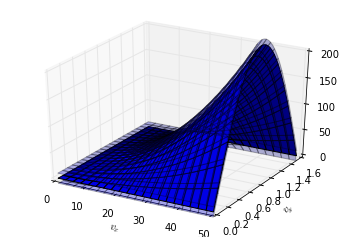

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
try:
    from scipy.constants import g, pi
except ImportError:
    g = 9.80665
    from math import pi
    
xx = np.linspace(0.5, 50, 200)
yy = np.linspace(1e-6, pi / 2, 200)
xx, yy = np.meshgrid(xx, yy)
points = np.stack([xx, yy], axis=2)
def s(coords):
    v, angle = coords
    return v * v * np.sin(2 * angle) / g 
dist = np.apply_along_axis(s, -1, points)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx, yy, dist)
ax.plot_surface(xx, yy, dist + 10, alpha=0.3)  # верхняя граница ответа "попал" в тренировочных данных
ax.plot_surface(xx, yy, dist - 10, alpha=0.3)  # нижняя граница ответа "попал" в тренировочных данных
plt.xlabel(r"$v_x$")
plt.ylabel(r"$v_y$")
xlim = plt.xlim()  # чтобы построить следующий график в том же масштабе
ylim = plt.ylim()  # чтобы построить следующий график в том же масштабе
zlim = ax.get_zlim()
ax.set_zlim(0, 200)
plt.show()

Осталось понять, как сравнить с этим решающую поверхность, полученную нашей сетью. Нарисуем все начальные точки вида (угол, скорость, дальность мишени), которые классифицируются как "будет попадание". То есть покажем натренированной нейронной сети много-много разных точек и отметим на графике те, которые, на её взгляд, соответствуют ситуации попадания в мишень. 

Так как точек много, будем смотреть только широкое "облако" около правильной поверхности, но не все точки в кубе. Осторожно: график будет строиться долго (мы $100\times 200\times 40 = 800\,000$ раз прогоняем данные через нейросеть)!

In [12]:
xx = np.linspace(0.5, 100, 100)
yy = np.linspace(0, pi / 2, 180)
dd = np.linspace( -10,  10, 40)  # только точки от -2.5 до 2.5 должны бы войти в график, но посмотрим
def normalize(a):
    """нормализует очередной вход тестовых данных, подготавливая его к обработке нейросетью"""
    return ((np.array(a) - means[:-1]) / stds[:-1])[:, np.newaxis]
dots = np.array([(x, y, d + s([x, y])) for x in xx for y in yy for d in dd 
                 if np.argmax(nn.feedforward(normalize((x, y, d + s([x, y]))))) == 0])

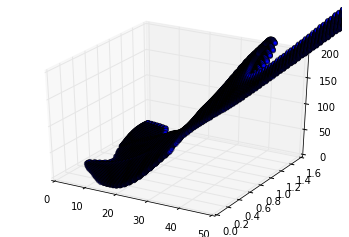

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(dots[:, 0], dots[:, 1], dots[:, 2], alpha=0.5)
plt.xlim(*xlim)
plt.ylim(*ylim)
ax.set_zlim(*zlim)
plt.show()

Итак, мы разобрались с тем, что предсказания наша сеть делает, и они примерно правильные. Но мы взяли просто сеть с потолка: почему именно 6 нейронов на внутреннем слое? Почему только один внутренний слой?
Давайте поэкспериментируем с этим!

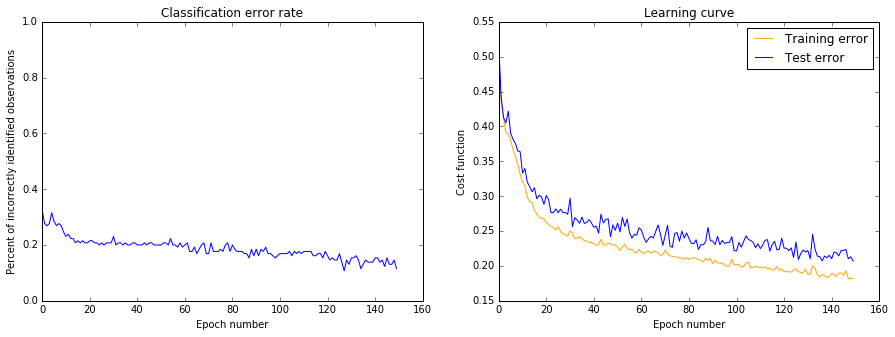

In [14]:
from ipywidgets import *
@interact(layer1=IntSlider(min=0, max=10, continuous_update=False, description="1st inner layer: ", value=6),
          layer2=IntSlider(min=0, max=10, continuous_update=False, description="2nd inner layer:"),
          layer3=IntSlider(min=0, max=10, continuous_update=False, description="3rd inner layer: "),
          batch_size=BoundedIntText(min=1, max=len(data), value=10, description="Batch size: "),
          learning_rate=Dropdown(options=["0.01", "0.05", "0.1", "0.5", "1", "5", "10"], 
                                 description="Learning rate: ")
         )
def learning_curve_by_network_structure(layer1, layer2, layer3, batch_size, learning_rate):
    layers = [x for x in [input_count, layer1, layer2, layer3, output_count] if x > 0]
    nn = Network(layers, output=False)
    learning_rate=float(learning_rate)
    
    CER = []
    cost_train = []
    cost_test  = []
    for _ in range(150):
        nn.SGD(training_data=train, epochs=1, mini_batch_size=batch_size, eta=learning_rate)
        CER.append(1 - nn.evaluate(test) / len(test))
        cost_test.append(cost_function(nn, test, onehot=False))
        cost_train.append(cost_function(nn, train, onehot=True))
    
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,2,1)
    plt.ylim(0, 1)
    plt.plot(CER)
    plt.title("Classification error rate")
    plt.ylabel("Percent of incorrectly identified observations")
    plt.xlabel("Epoch number")
    
    fig.add_subplot(1,2,2)
    plt.plot(cost_train, label="Training error", color="orange")
    plt.plot(cost_test, label="Test error", color="blue")
    plt.title("Learning curve")
    plt.ylabel("Cost function")
    plt.xlabel("Epoch number")
    plt.legend()
    plt.show()

Этот виджет и ваши взаимодействия с ним должны оставить у вас в голове один большой вопрос: "А как вообще выбирать архитектуру сети, чтобы что-нибудь работало"?

## Регуляризация
Отлично, мы достигаем примерно 90%-ной точности только за счёт конструкции самой сети. Можно ли лучше?
Давайте разберёмся со стандартными приёмами (которые, кстати, будут гарантированно объявлять более проcтые модели более хорошими).

Напоминание: целевая функция при применении $\ell_1$-регуляризации выглядит так: 
$$J_1 = \frac{1}{n}\sum_{i=1}^n \left\vert\hat y_i - y_i\right\vert^2 + \lambda_1\sum_{j}\left\vert w_j\right\vert,$$
где $w_j$ - любой вес в том смысле, что это любое $w_{jk}^l$.

Целевая функция для $\ell_2$-регуляризации выглядит похожим образом:
$$J_2 = \frac{1}{n}\sum_{i=1}^n \left\vert\hat y_i - y_i\right\vert^2 + \lambda_2\frac{1}{2}\sum_{j}\left\vert w_j\right\vert^2,$$
поэтому обычно имеет смысл их объединить и задавать параметрами коэффициенты $\lambda_1$ и $\lambda_2$, чтобы не плодить сущности:
$$J_r = \frac{1}{n}\sum_{i=1}^n \left\vert\hat y_i - y_i\right\vert^2 + \lambda_1\sum_{j}\left\vert w_j\right\vert + \lambda_2\frac{1}{2}\sum_{j}\left\vert w_j\right\vert^2.$$

Упражнение: посчитайте производные целевой функции $J_r$ по весам и проверьте себя и нас в коде ниже: правильно ли мы считаем эти производные?

In [15]:
class RegularizedNetwork(Network):
    def __init__(self, sizes, output=True, l1=0, l2=0):
        super().__init__(sizes, output)
        self.l1 = l1
        self.l2 = l2
        
    def update_mini_batch(self, mini_batch, eta):
        """
        Обновить веса и смещения нейронной сети, сделав шаг градиентного
        спуска на основе алгоритма обратного распространения ошибки, примененного
        к одному mini batch. Учесть штрафы за L1 и L2.
        ``mini_batch`` - список кортежей вида ``(x, y)``,
        ``eta`` - величина шага (learning rate).
        """
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        eps = eta / len(mini_batch)
        self.weights = [w - eps * nw - self.l1 * np.sign(w) - self.l2 * w for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

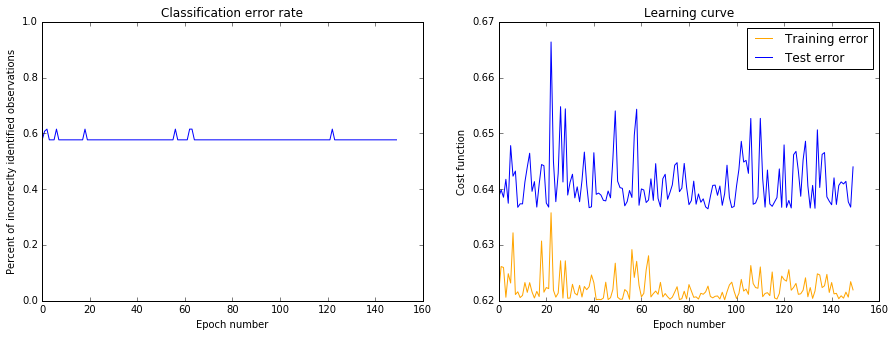

In [17]:
%matplotlib inline
from ipywidgets import *
@interact(layer1=IntSlider(min=0, max=10, continuous_update=False, description="1st inner layer: ", value=6),
          layer2=IntSlider(min=0, max=10, continuous_update=False, description="2nd inner layer:"),
          layer3=IntSlider(min=0, max=10, continuous_update=False, description="3rd inner layer: "),
          batch_size=BoundedIntText(min=1, max=len(data), value=10, description="Batch size: "),
          learning_rate=Dropdown(options=["0.01", "0.05", "0.1", "0.5", "1", "5", "10"], 
                                 value="0.01", description="Learning rate: "),
          l1=Dropdown(options=["0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], value="0.0001", 
                      description="$\ell_1:$"),
          l2=Dropdown(options=["0", "0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05", "0.1"], value="0.0001", 
                      description="$\ell_2:$")
         )
def learning_curve_by_network_structure_and_regularization(layer1, layer2, layer3, batch_size, learning_rate, l1, l2):
    layers = [x for x in [input_count, layer1, layer2, layer3, output_count] if x > 0]
    nn = RegularizedNetwork(layers, output=False, l1=float(l1), l2=float(l2))
    learning_rate=float(learning_rate)
    
    CER = []
    cost_train = []
    cost_test  = []
    for _ in range(150):
        nn.SGD(training_data=train, epochs=1, mini_batch_size=batch_size, eta=learning_rate)
        CER.append(1 - nn.evaluate(test) / len(test))
        cost_test.append(cost_function(nn, test, onehot=False))
        cost_train.append(cost_function(nn, train, onehot=True))
    
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,2,1)
    plt.ylim(0, 1)
    plt.plot(CER)
    plt.title("Classification error rate")
    plt.ylabel("Percent of incorreclty identified observations")
    plt.xlabel("Epoch number")
    
    fig.add_subplot(1,2,2)
    plt.plot(cost_train, label="Training error", color="orange")
    plt.plot(cost_test, label="Test error", color="blue")
    plt.title("Learning curve")
    plt.ylabel("Cost function")
    plt.xlabel("Epoch number")
    plt.legend()
    plt.show()

Надеюсь, вы будете так же увлечённо рассматривать эти графики, как это делали мы (кое-кто час заворожённо двигал ползунки, всё больше и больше проникаясь пониманием!) Если у вас появились какие-то гениальные мысли (помимо двух заданий на интерпретацию графиков, которые ждут вас на Stepic.Org), не стесняйтесь писать их в комментариях к уроку!